# Character level MLP Language model

`References:`<br>
https://www.youtube.com/watch?v=TCH_1BHY58I<br>
https://www.youtube.com/watch?v=P6sfmUTpUmc

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
plt.style.use('ggplot')

In [2]:
words = open('names.txt','r').read().splitlines()

In [3]:
context_window = 3

##### Creating a word-integer mapping

In [4]:
def char2int(words:list[str]):
    chars = sorted(list(set(''.join(words))))
    stoi = {s:i+1 for i,s in enumerate(chars)}
    stoi['.'] = 0
    itos = {i:s for s,i in stoi.items()}
    return stoi, itos
    
stoi, itos = char2int(words)
vocab_size = len(stoi)

In [57]:
vocab_size

27

#### Transforming integer mapped data to tensors

In [5]:
def build_dataset(context_window,stoi,words:list[str]):
    X, y = [], []
    for w in words:
        context = [0] * context_window
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            y.append(ix)
            #print('{}--->{}'.format(''.join(self.itos[i] for i in context),self.itos[ix]))    
            context = context[1:] + [ix]
        #print(f'{w}\n')    
    X = torch.tensor(X)
    y = torch.tensor(y)
    return X, y

X,y = build_dataset(3,stoi,words)

#### Creating train, val and test split

In [6]:
def create_split(words:list[str],stoi,train_ratio=0.8,val_ratio=0.1):
    random.shuffle(words)
    n1 = int(train_ratio*len(words))
    n2 = int((train_ratio+val_ratio)*len(words))
    X_train, y_train = build_dataset(3,stoi,words[:n1])
    X_val, y_val = build_dataset(3,stoi,words[n1:n2])
    X_test, y_test = build_dataset(3,stoi,words[n2:])
    return X_train,y_train, X_val, y_val, X_test, y_test

X_train,y_train, X_val, y_val, X_test, y_test = create_split(words,stoi)

In [7]:
print('Input Shape: {}\nTrain split shape: {}\nValid split shape: {}\nTest split shape: {}'.format(X.shape,X_train.shape, X_val.shape, X_test.shape))

Input Shape: torch.Size([228146, 3])
Train split shape: torch.Size([182651, 3])
Valid split shape: torch.Size([22765, 3])
Test split shape: torch.Size([22730, 3])


#### Intialising weights and biases

In [8]:
embedding_dim=10
hidden_dim=200

In [9]:
C = torch.randn(vocab_size,embedding_dim)
w1 = torch.randn((context_window*embedding_dim,hidden_dim)) *0.1 # to ensure that tanh don't kill neurons
w1  = torch.nn.init.kaiming_uniform_(w1, mode='fan_in', nonlinearity='tanh') # to ensusre the standard deviation remains same
#b1 =  torch.randn(hidden_dim) *0.01
w2 = torch.randn((hidden_dim,vocab_size)) * 0.01 # otherwise initial loss will be significantly higher
b2 = torch.zeros(vocab_size) 
# normalising scale and shift parameters
bngain = torch.ones((1, hidden_dim))
bnbias = torch.zeros((1,hidden_dim))
bnmean_running = torch.zeros((1,hidden_dim))
bnstd_running =  torch.ones((1,hidden_dim))

parameters = [C, w1, w2, b2, bngain, bnbias]

for p in parameters:
    p.requires_grad =True  

In [10]:
print(sum(p.nelement() for p in parameters))

12097


#### Training the network

In [11]:
NUM_ITER = 1e4
batch_size = 32
lrs = 0.1

In [12]:
for i in range(0,int(NUM_ITER)):
    
    ix = torch.randint(0,int(X_train.shape[0]),(batch_size,))

    embeddings = C[X_train[ix]] 
    embcat = embeddings.view(embeddings.shape[0], -1) # concatenate the vectors
    
    # Forward pass
    hpreact = embcat  @ w1 #+ b1 , uneccessary as it will get subtracted in hpreact-bnmeani and will not recieve any gradients
    
    # batch normalisation : to normalise the outputs such that output's probability distribution has same statistics as neural net
    bnmeani = hpreact.mean(0,keepdim=True)
    bnstdi  = hpreact.std(0,keepdim=True) 
    hpreact =  bngain * ((hpreact - bnmeani) / bnstdi)+ bnbias
    with torch.no_grad():
        # Running values will be mostly orignal values with slight adjustments
        bnmean_running = 0.999* bnmean_running + 0.001*bnmeani  # 0.001 -> momentum, for smaller batch sizes lower momentum is preferred
        bnstd_running = 0.999*bnstd_running + 0.001*bnstdi
        
        
    h = torch.tanh(hpreact)
    logits = h @ w2 + b2
    loss = F.cross_entropy(logits,y_train[ix])  
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # Optimization
    for p in parameters:
        p.data -= lrs * p.grad
        
        
    if i % (NUM_ITER/10) == 0:
        lrs /= 1.26 # 1.26**10 = 10
        print('Epoch : {} | Loss: {}'.format(i,loss.item()))
    
print('Final Loss: {}'.format(loss.item()))

Epoch : 0 | Loss: 3.32779598236084


Epoch : 1000 | Loss: 2.3237597942352295
Epoch : 2000 | Loss: 2.2983129024505615
Epoch : 3000 | Loss: 2.339892625808716
Epoch : 4000 | Loss: 2.2183780670166016
Epoch : 5000 | Loss: 2.392392635345459
Epoch : 6000 | Loss: 2.134211540222168
Epoch : 7000 | Loss: 2.3218231201171875
Epoch : 8000 | Loss: 1.7697572708129883
Epoch : 9000 | Loss: 2.277451276779175
Final Loss: 2.4636473655700684


#### Problems

<h4>Problem 1 </h4>

If we get histograms with most of the data concentrated at 1 and -1, than the backpropogating gradients through tanh will always be zero.
$$\frac{\partial tanh(y)}{\partial y} = (1-tanh^2(y))*global\;gradient$$
<br> `Solution`: Multiply the weights and biases post activation function by some small number < 0.

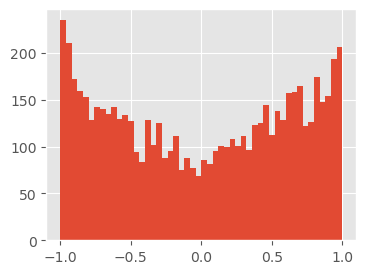

In [13]:
plt.figure(figsize=(4,3))
plt.hist(h.view(-1).tolist(),50);

<h4>Problem 2</h4>
If there are white spots in below splots, they depict the neurons which are dead due to tanh squashing the outputs to 1 or -1. If an entire column becomes white than the subesquent backpropgation will result in no gradient flow.
<br>`Solution`: Multiply pre activation weights and biases by numbers < 0.

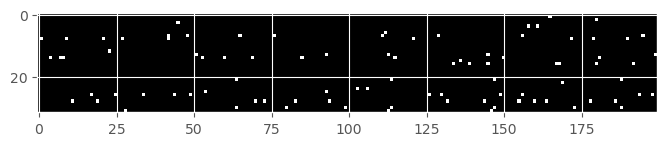

In [14]:
plt.figure(figsize=(8,6))
plt.imshow(h.abs() > 0.99, cmap = 'grey', interpolation='nearest')

In [15]:
with torch.no_grad():
  # pass the training set through
  emb = C[X_train]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ w1 
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)

#### Comparing train and validation errors

In [16]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (X_train, y_train),
    'val': (X_val, y_val),
    'test': (X_test, y_test),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ w1 
  #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ w2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.2268056869506836
val 2.2401604652404785


## Making the code more systematic

In [17]:
class Linear:
    def __init__(self,input_dim,output_dim,bias=True) -> None:
        self.weight = torch.randn((input_dim,output_dim)) / input_dim**0.5
        self.bias = torch.zeros(output_dim) if bias else None
        
    def __call__(self,x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

In [73]:
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

In [19]:
class Tanh:
    def __call__(self,x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

In [22]:
n_embd = 10
n_hidden = 100
context_window = 3

In [23]:
layers = [
   Linear(n_embd * context_window, n_hidden), Tanh(),
   Linear(           n_hidden, n_hidden), Tanh(),
   Linear(           n_hidden, n_hidden), Tanh(),
   Linear(           n_hidden, n_hidden), Tanh(),
   Linear(           n_hidden, n_hidden), Tanh(),
   Linear(           n_hidden, vocab_size),
]

#### Training without Batch Normalisation

`Important:` Without the batch normalisation the layer intialisation gain has to be callibrated very carefully.

In [52]:
with torch.no_grad():
  # last layer: make less confident
  #layers[-1].gamma *= 0.1
  layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

46497


In [53]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, X_train.shape[0], (batch_size,))
  Xb, Yb = X_train[ix], y_train[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 2.8141


#### Diagnosing our model

##### Plot 1: Histogram of forward pass activation Function

`Expectations:` <br>1. In case of tanh activation we would like our outputs to not peak at some particular value, especially at -1, 0 or 1. We would like the distibution to be uniform.</br>
<br>2. We would expect out outputs to have same statistics that is mean and standard deviation should be 0 and 1 respectively.</br>
<br>3. Also we expect all layers to have similar statistics. That is the curves should overlap.</br>
<br>4. Saturation metric is percentage of outputs falling in tails of tanh i.e around -1 or 1. It should remain as low as possible for passing gradients in backward pass.</be>

layer 1 (      Tanh): mean -0.00, std 0.50, saturated: 1.66%
layer 3 (      Tanh): mean +0.02, std 0.51, saturated: 1.69%
layer 5 (      Tanh): mean -0.01, std 0.61, saturated: 4.72%
layer 7 (      Tanh): mean -0.01, std 0.70, saturated: 10.88%
layer 9 (      Tanh): mean +0.02, std 0.58, saturated: 16.94%


Text(0.5, 1.0, 'activation distribution')

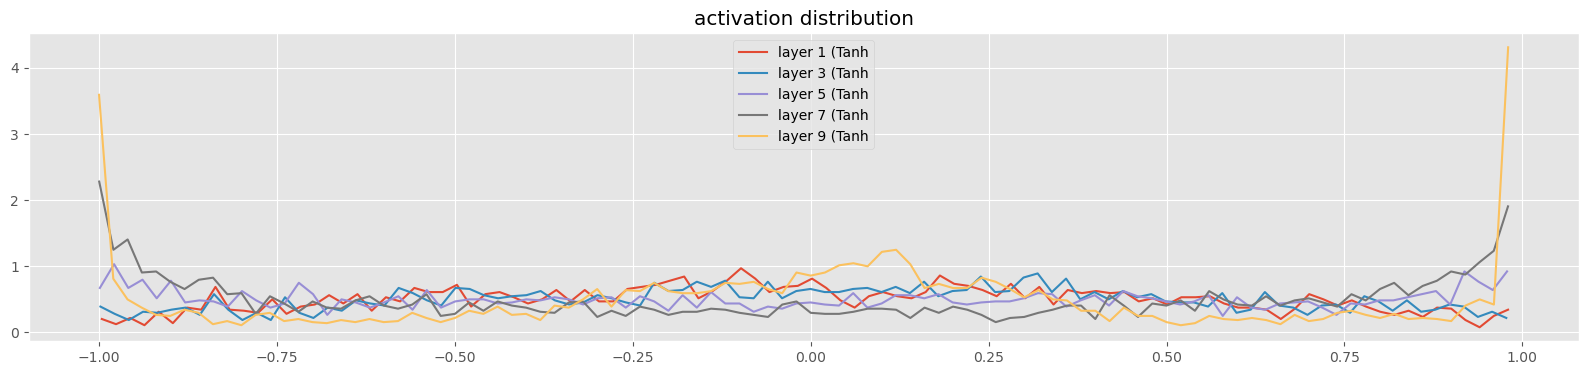

In [54]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

##### Plot 2: Histogram of gradients

`Expectations:`
<br>1. We want all the layers to have simialr gradiens. There is not shrinking or explosions in gradients.

layer 1 (      Tanh): mean -0.000010, std 9.173370e-04
layer 3 (      Tanh): mean +0.000006, std 7.620177e-04
layer 5 (      Tanh): mean +0.000010, std 6.163649e-04
layer 7 (      Tanh): mean -0.000017, std 6.834695e-04
layer 9 (      Tanh): mean +0.000011, std 1.364975e-03


Text(0.5, 1.0, 'gradient distribution')

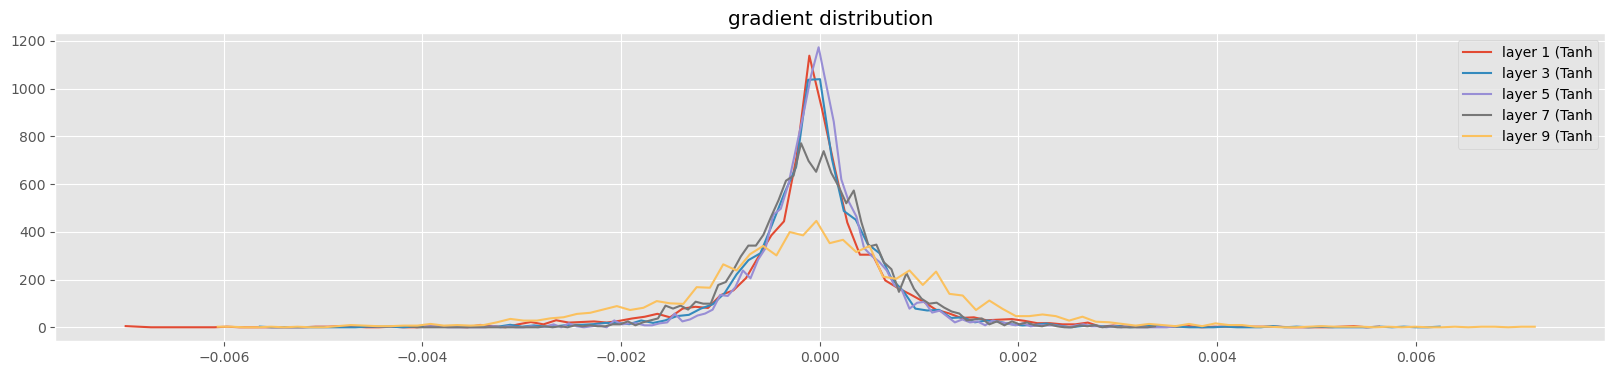

In [55]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

##### Plot 3. Histogram of gadient to data ratio

`Expecatations:`
<br>1. We expect the grad to data ratio should be small, so that during optimisation $$x_{t+1} = x_{t} - \alpha*\varDelta x$$
the change isn't significant.</br>
<br>2. All layers have similar ratios, otherwise layer with greater ratios will train faster if using SGD.
<br>This is seen in the final layer. Due to the dimensions coming down from 100 to vocab size (27) to keep softmax at last layer unconfident. This effect altough stabelizes with higher iterations.

weight   (27, 10) | mean -0.001127 | std 8.582219e-03 | grad:data ratio 8.857938e-03
weight  (30, 100) | mean -0.000016 | std 4.246070e-03 | grad:data ratio 3.548859e-02
weight (100, 100) | mean +0.000001 | std 1.736704e-03 | grad:data ratio 3.555100e-02
weight (100, 100) | mean +0.000012 | std 1.608555e-03 | grad:data ratio 3.243297e-02
weight (100, 100) | mean -0.000002 | std 1.952825e-03 | grad:data ratio 3.804944e-02
weight (100, 100) | mean -0.000024 | std 3.182001e-03 | grad:data ratio 5.813516e-02
weight  (100, 27) | mean +0.000000 | std 2.097536e-02 | grad:data ratio 4.977354e-01


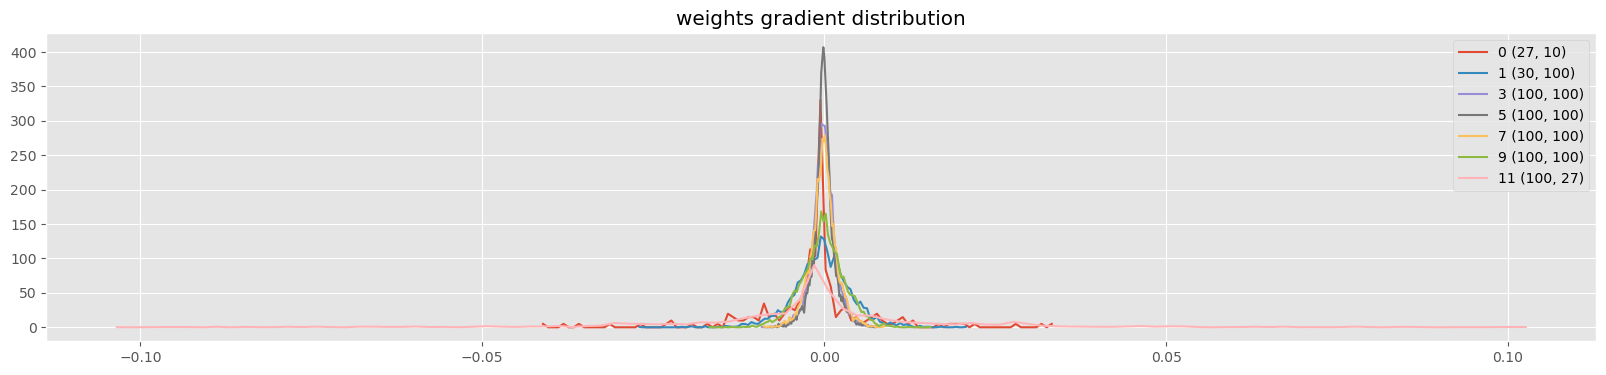

In [56]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

##### Plot 5. Update to data ratio

`Expectaions:`
<br>1. We expect the ratios to around 1e-3. Below it would mean that the network is learning too slow and above it would mean that network is learning faster.

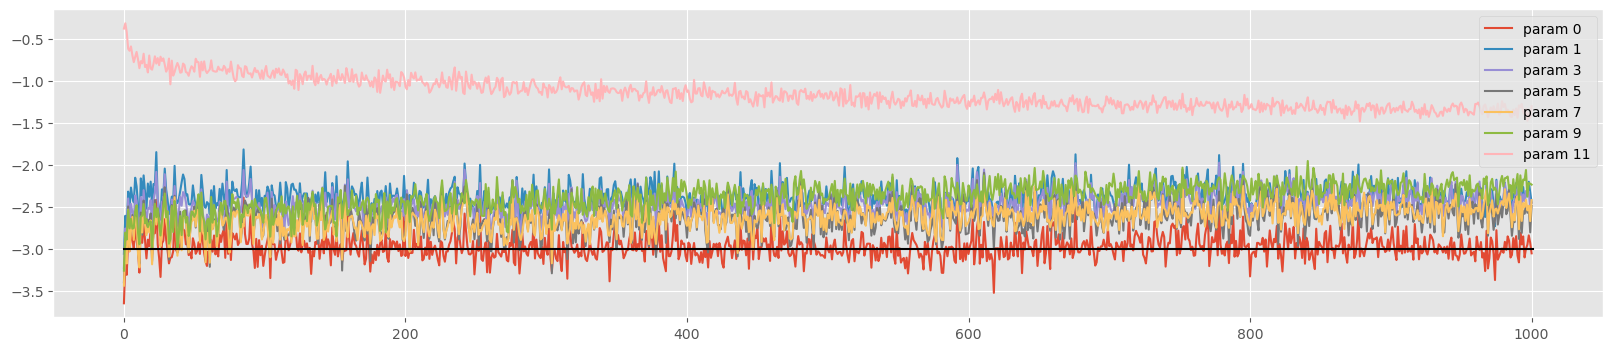

In [58]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

#### Training with batch normalisation

`Benifit:` The layer initialising gain has to not be precisely calibrated anymore.

In [74]:
C = torch.randn((vocab_size, n_embd),)
layers = [
  Linear(n_embd * context_window, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]

In [75]:
with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

47024


In [76]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, X_train.shape[0], (batch_size,))
  Xb, Yb = X_train[ix], y_train[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.3182


layer 2 (      Tanh): mean +0.00, std 0.63, saturated: 3.16%
layer 5 (      Tanh): mean +0.00, std 0.64, saturated: 2.91%
layer 8 (      Tanh): mean -0.00, std 0.65, saturated: 2.25%
layer 11 (      Tanh): mean -0.00, std 0.65, saturated: 1.72%
layer 14 (      Tanh): mean -0.01, std 0.65, saturated: 1.53%


Text(0.5, 1.0, 'activation distribution')

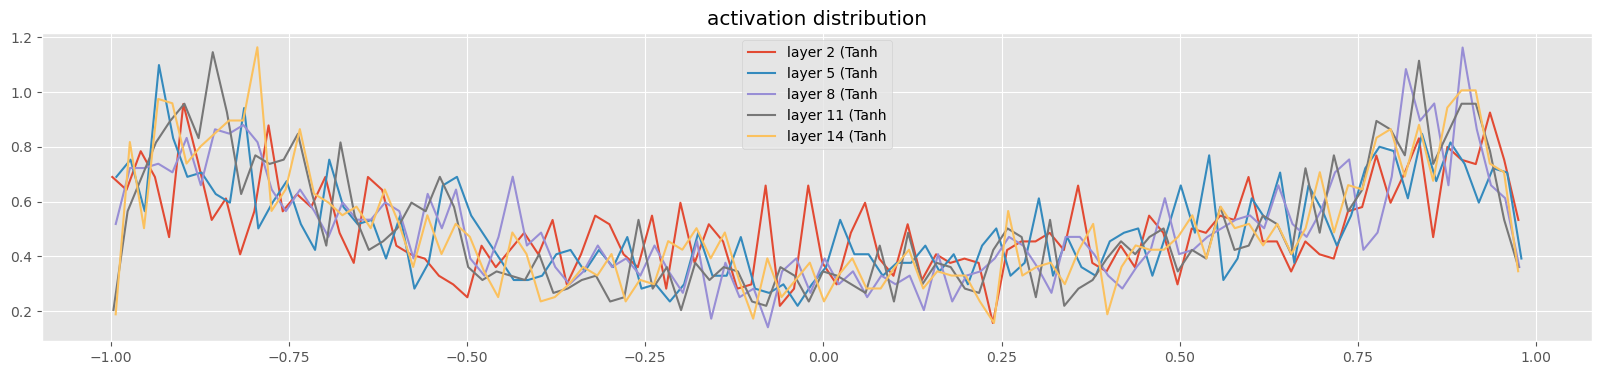

In [77]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

layer 2 (      Tanh): mean +0.000000, std 2.928539e-03
layer 5 (      Tanh): mean -0.000000, std 2.267729e-03
layer 8 (      Tanh): mean +0.000000, std 2.121058e-03
layer 11 (      Tanh): mean -0.000000, std 1.994827e-03
layer 14 (      Tanh): mean -0.000000, std 1.914027e-03


Text(0.5, 1.0, 'gradient distribution')

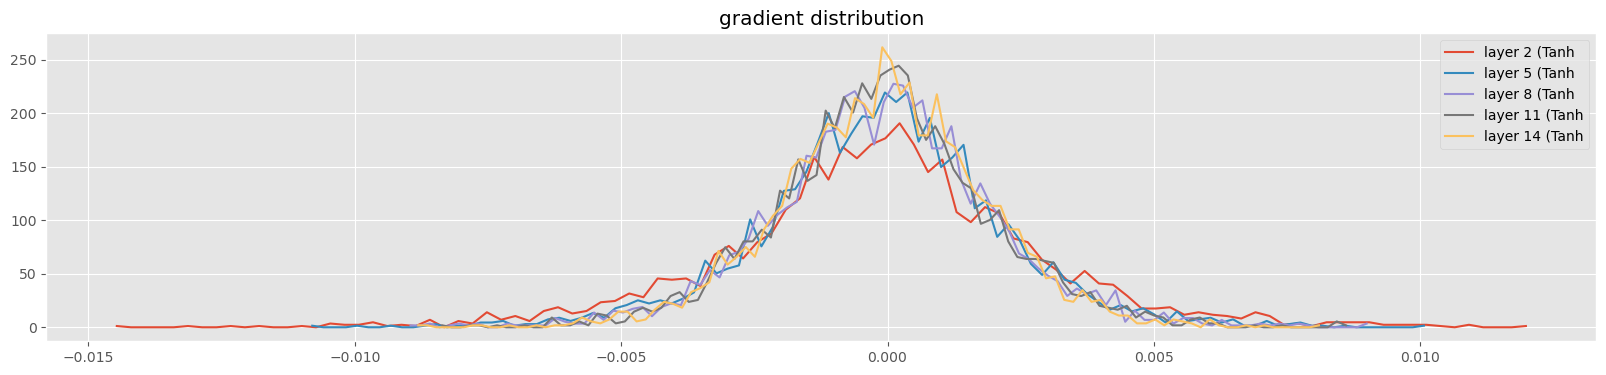

In [78]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean -0.000000 | std 9.965549e-03 | grad:data ratio 9.748455e-03
weight  (30, 100) | mean -0.000276 | std 1.278220e-02 | grad:data ratio 6.900634e-02
weight (100, 100) | mean +0.000217 | std 7.835370e-03 | grad:data ratio 7.709234e-02
weight (100, 100) | mean -0.000031 | std 6.793193e-03 | grad:data ratio 6.670114e-02
weight (100, 100) | mean -0.000006 | std 6.161589e-03 | grad:data ratio 6.036415e-02
weight (100, 100) | mean -0.000052 | std 5.814692e-03 | grad:data ratio 5.718186e-02
weight  (100, 27) | mean +0.000101 | std 1.131189e-02 | grad:data ratio 1.081186e-01


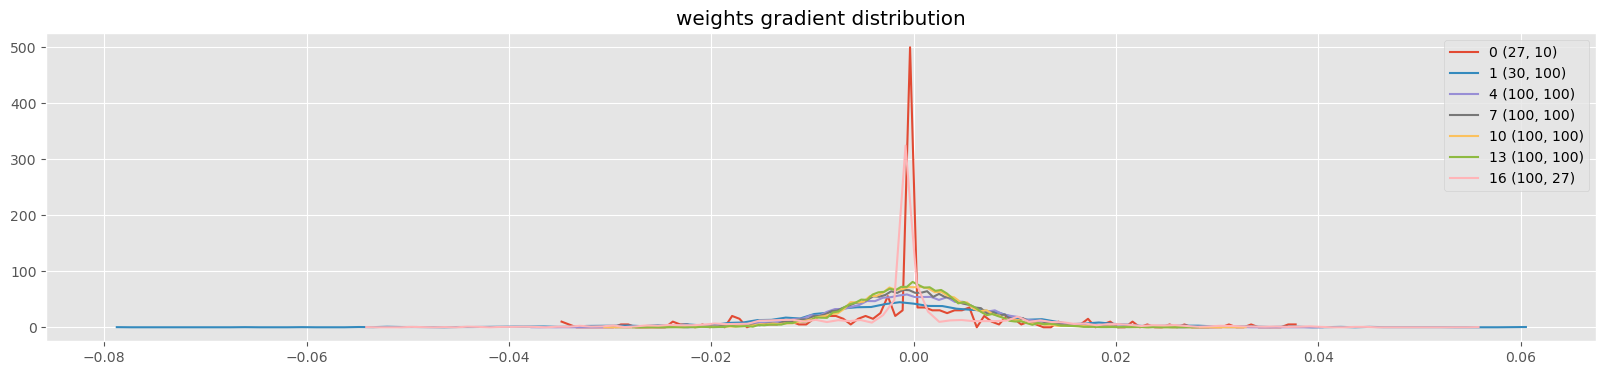

In [79]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

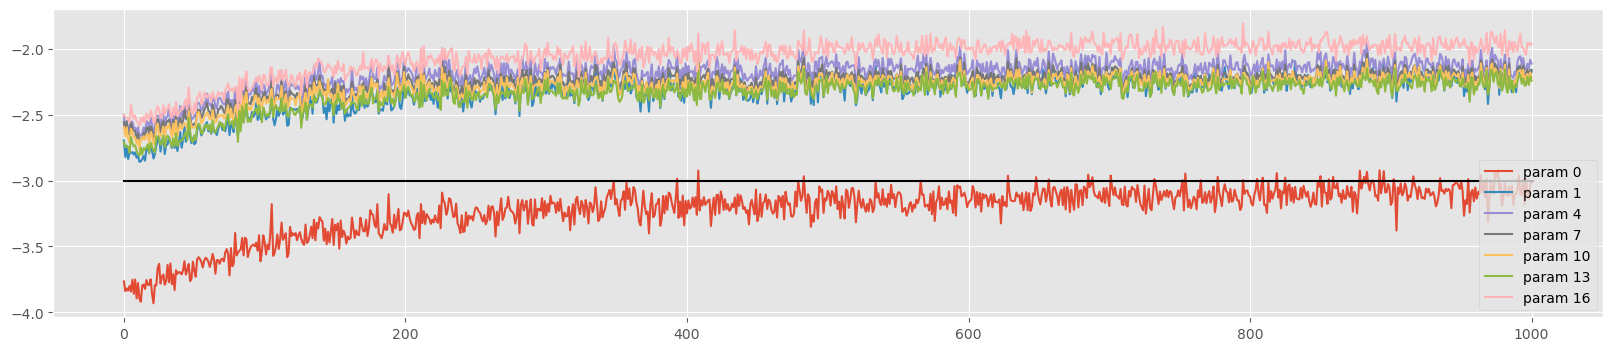

In [80]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);


In [82]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y =  {
    'train': (X_train, y_train),
    'val': (X_val, y_val),
    'test': (X_test, y_test),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y)
  print(split, loss.item())

# put layers into eval mode
for layer in layers:
  layer.training = False
split_loss('train')
split_loss('val')

train 2.402642250061035
val 2.4076790809631348


In [84]:
for _ in range(20):
    
    out = []
    context = [0] * context_window # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out)) # decode and print the generated word

lyn.
maizla.
sri.
rzem.
kirarxi.
dfeelxrins.
araliokenpsonah.
rilal.
dufe.
rica.
niliqinqilen.
eholnyar.
marjynan.
suynn.
zzeena.
maynvelento.
caiahnaxe.
karoril.
mar.
tainli.
